In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices

In [ ]:
#Import the data set
df = pd.read_csv('/content/ratings_Electronics (1).csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

In [ ]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  77618
No of columns =  3


In [ ]:
# Find number of missing values in each column
df.isna().sum()

user_id    0
prod_id    1
rating     1
dtype: int64

In [ ]:
# Summary statistics of 'rating' variable
df['rating'].describe()

count    77617.000000
mean         4.055336
std          1.339192
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

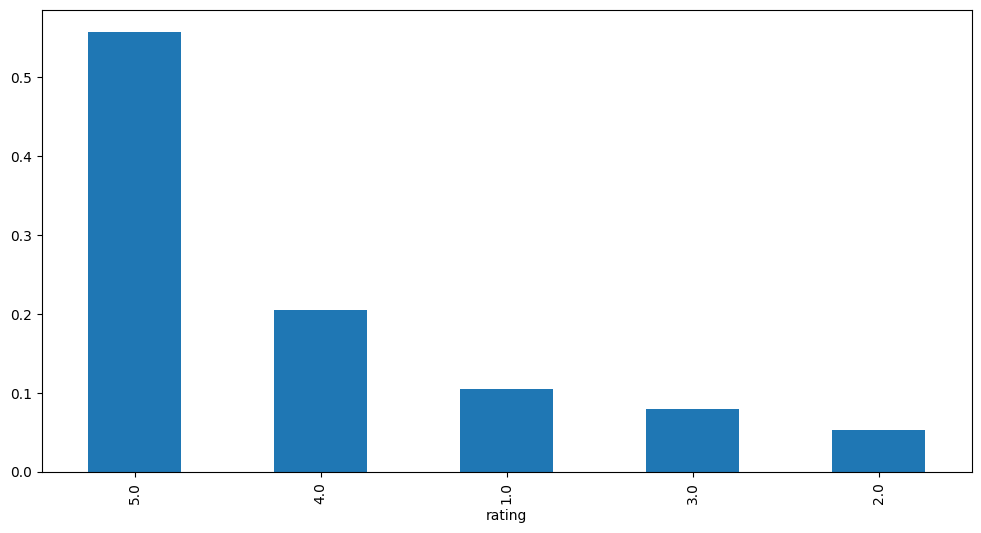

In [ ]:

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

In [ ]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  70713
Number of unique ITEMS in Raw data =  5528


In [ ]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A231WM2Z2JL0U3    67
A2BGZ52M908MJY    45
AY8Q1X7G96HV5     36
A1MJMYLRTZ76ZX    29
A1NVD0TKNS1GT5    29
A1RPTVW5VEOSI     26
ALUNVOQRXOZIA     25
A3MEIR72XKQY88    24
A243HY69GIAHFI    23
A23ZO1BVFFLGHO    22
dtype: int64

In [ ]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 5].index)]

In [ ]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 2200
Number of unique USERS in the final data =  279
Number of unique PRODUCTS in the final data =  1222


#Rank Based Recommendation System

In [ ]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (279, 1222)
given_num_of_ratings =  2200
possible_num_of_ratings =  340938
density: 0.65%


prod_id,0972683275,1400501466,1400501520,1400501776,1400532655,140053271X,1400599997,1400698987,9043413585,998376234X,...,B000050YAP,B000050ZE2,B000050ZF5,B000050ZR1,B000050ZRE,B000050ZS3,B000050ZTY,B000050ZUC,B0000510NY,B0000510O4
user_id,,,,,,,,,,,,,,,,,,,,,
A10C84Y38RT22P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10DIDVYDN2Q5Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A123WML9K2WDX4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean() # removed .mean()['rating']

#Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count() # removed .count()['rating']

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
0972683275,5.0,1
B00003CW97,5.0,1
B00004Y7CF,5.0,3
B00003CWAH,5.0,1
B00003CWB4,5.0,1


In [ ]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values('avg_rating',ascending=False)

    return recommendations.index[:n]

In [ ]:
list(top_n_products(final_rating, 5, 5))

['B00004Z5M1', 'B00000J08C', 'B00000J061', 'B00004TDN4', 'B00004WHF9']

In [ ]:
list(top_n_products(final_rating, 5, 40))

['B00004SB92']

#Collaborative Filtering based Recommendation System

In [ ]:
final_ratings_matrix.head()

prod_id,0972683275,1400501466,1400501520,1400501776,1400532655,140053271X,1400599997,1400698987,9043413585,998376234X,...,B000050YAP,B000050ZE2,B000050ZF5,B000050ZR1,B000050ZRE,B000050ZS3,B000050ZTY,B000050ZUC,B0000510NY,B0000510O4
user_id,,,,,,,,,,,,,,,,,,,,,
A10C84Y38RT22P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10DIDVYDN2Q5Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A123WML9K2WDX4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
final_ratings_matrix.shape

(279, 1222)

In [ ]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0972683275,1400501466,1400501520,1400501776,1400532655,140053271X,1400599997,1400698987,9043413585,998376234X,...,B000050YAP,B000050ZE2,B000050ZF5,B000050ZR1,B000050ZRE,B000050ZS3,B000050ZTY,B000050ZUC,B0000510NY,B0000510O4
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Actual ratings given by users
final_ratings_matrix.shape

(279, 1222)

In [ ]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows

        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])

        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list

    #Remove the original user and its similarity score and keep only other similar users
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

In [ ]:
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar

[99, 59, 91, 51, 53, 197, 119, 240, 49, 145]

In [ ]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.43166487]]),
 array([[0.27175518]]),
 array([[0.27175518]]),
 array([[0.2483049]]),
 array([[0.24605775]]),
 array([[0.21831772]]),
 array([[0.212778]]),
 array([[0.13748167]]),
 array([[0.11759271]]),
 array([[0.11757927]])]

In [ ]:
similar = similar_users(200, final_ratings_matrix)[0][0:10]
similar

[203, 17, 204, 248, 66, 108, 245, 10, 34, 161]

In [ ]:
#Print the similarity score
similar_users(200,final_ratings_matrix)[1][0:10]

[array([[0.25189636]]),
 array([[0.19611614]]),
 array([[0.18531233]]),
 array([[0.18430245]]),
 array([[0.17503501]]),
 array([[0.17089648]]),
 array([[0.17089648]]),
 array([[0.16778901]]),
 array([[0.15811388]]),
 array([[0.15811388]])]

#Function to recommend products

In [ ]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

In [ ]:
recommendations(3,5,final_ratings_matrix)

['B0000228GF', 'B00000JD4T', 'B00000K2Z0', 'B00000JMRX', 'B00004VX3T']

In [ ]:
recommendations(200,4,final_ratings_matrix)

['1400532655', 'B00003G1RG', 'B00004Z5L8', 'B00004VX3T']

#SVD

In [ ]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

prod_id
0972683275    0.017921
1400501466    0.017921
1400501520    0.017921
1400501776    0.017921
1400532655    0.003584
dtype: float64